# 5. Classification of Cancer or Non-Cancer with Classifiers


* After loading and processing the dataset, each sample's largest nodule is a subset.
* Indicate if it is cancerous or not. As an alternative, generate labels at random using the same class ratio.
* To convert numerical data into categorical data for multinomial naive bayes classification, discretize the features by rounding or converting to percentiles.
* Using GaussianNB, MultinomialNB, Logistic Regression, Random Forest, Gradient Boosting, SVM w/rbf kernel, and SVM w/linear kernel, set up a stratified K-fold and do cross validation.
* Assemble a group of classifiers
* Analyze the results of classifiers trained using random labels.
* Utilize grid search to optimize model parameters.

In [1]:

#input list of tables generated from TrainUnet.ipynb
tablelist=['DSBPatientNoduleIndex.csv','DSBPatientNoduleIndex369-629.csv','DSBPatientNoduleIndex630-1199.csv','DSBPatientNoduleIndex1200-1594.csv', 'DSBPatientNoduleIndexTest.csv']


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import dicom
import os
import scipy.ndimage
import time
from keras.callbacks import ModelCheckpoint
import h5py
from sklearn.cluster import KMeans
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


import random
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,log_loss
from sklearn.model_selection import cross_val_score
from scipy.ndimage.measurements import center_of_mass, label
from skimage.measure import regionprops
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from scipy.stats import percentileofscore

import keras
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import plot_model
#import unet_model
import scipy as sp


Using TensorFlow backend.
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load and process dataset

In [2]:
#load tables and concatenate
table=pd.read_csv(tablelist[0])
if len(tablelist)>1:
    for file in tablelist[1:]:
        temptable=pd.read_csv(file)
        table=pd.concat([table,temptable])
table=table.reset_index()

table[:10]

,index,Area,Diameter,DiameterMajor,Eccentricity,LargestNoduleArea,MeanHU,NoduleIndex,Patient,Spiculation,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1
0,0,89.359329,10.645108,13.594830,0.713720,89,-272.820221,55,0015ceb851d7251b8f399e39779d1e7d,0.864078,0,0,NaN
1,1,71.400085,9.507892,12.956937,0.801334,71,-236.535217,56,0015ceb851d7251b8f399e39779d1e7d,0.910256,1,1,NaN
2,2,39.051132,6.863663,8.486004,0.708520,37,-173.769226,57,0015ceb851d7251b8f399e39779d1e7d,0.948718,2,2,NaN
3,3,63.034634,8.956232,12.397636,0.784063,63,-307.714294,58,0015ceb851d7251b8f399e39779d1e7d,0.797468,3,3,NaN
4,4,25.141571,5.753627,7.122801,0.662585,26,-366.500000,59,0015ceb851d7251b8f399e39779d1e7d,0.866667,4,4,NaN
5,5,42.820370,7.312733,9.713572,0.820839,42,-319.666656,66,0015ceb851d7251b8f399e39779d1e7d,0.954545,5,5,NaN
6,6,55.689487,8.519076,9.886418,0.610325,57,-367.298248,67,0015ceb851d7251b8f399e39779d1e7d,0.863636,6,6,NaN
7,7,5.780643,2.763953,3.265986,0.790569,6,-446.000000,110,0015ceb851d7251b8f399e39779d1e7d,1.000000,7,7,NaN
8,8,16.465515,4.513517,6.571094,0.845376,16,-468.562500,116,0015ceb851d7251b8f399e39779d1e7d,0.800000,8,8,NaN
9,9,37.294971,6.955796,8.292937,0.707234,38,-382.947357,119,0015ceb851d7251b8f399e39779d1e7d,0.974359,9,9,NaN


In [3]:
#Subset largest nodule for each sample and label as cancer or non-cancer
malignantlabel=[]
malignancytable=pd.concat([pd.read_csv("stage1_labels.csv"),pd.read_csv("stage1_solution.csv")])
patients=malignancytable["id"].values
index=0
indx=[]
for patient in patients:
    nodulearea=table[["LargestNoduleArea","NoduleIndex","MeanHU"]].loc[table["Patient"]==patient]
    if len(nodulearea)>0:
        malignantlabel.append(malignancytable["cancer"].loc[malignancytable["id"]==patient].values[0].astype(np.bool))
        indx.append(nodulearea["NoduleIndex"].loc[nodulearea["LargestNoduleArea"]==max(nodulearea["LargestNoduleArea"])].index[0])
inputfeatures=table.iloc[indx]
inputfeatures["label"]=malignantlabel
TFratio=len([a for a in malignantlabel if a==True])/len(malignantlabel)
TFratio
randomlabel=np.random.choice([0, 1], size=(len(malignantlabel),), p=[(1-TFratio), TFratio])
Xtrain, Xtest, Ytrain, Ytest = train_test_split(inputfeatures,malignantlabel,test_size=.30, random_state=42)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


## Exploratory Analysis

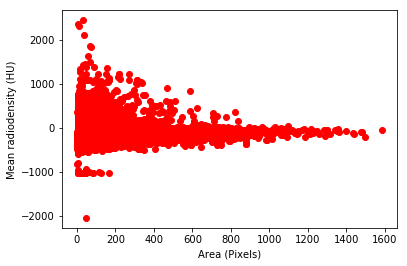

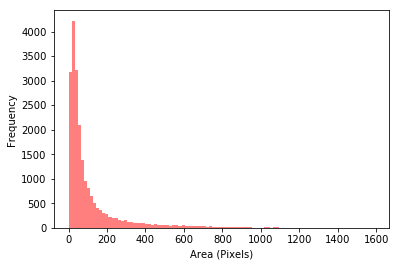

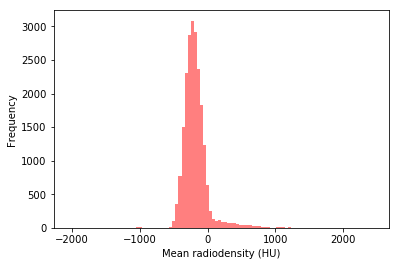

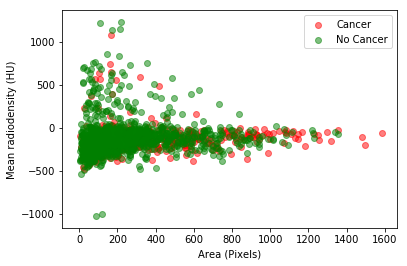

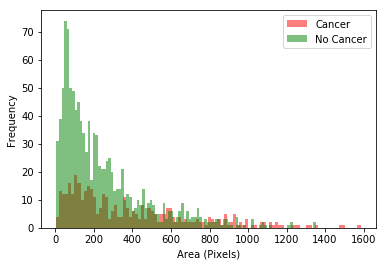

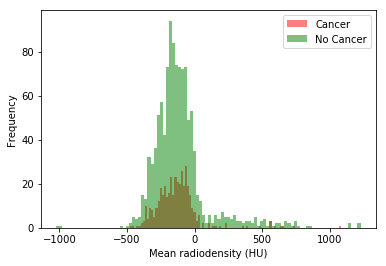

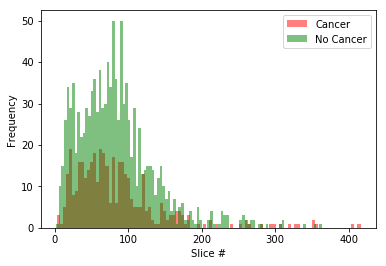

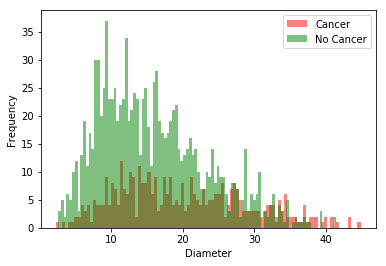

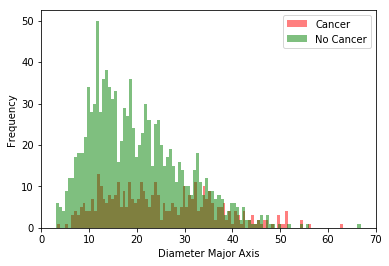

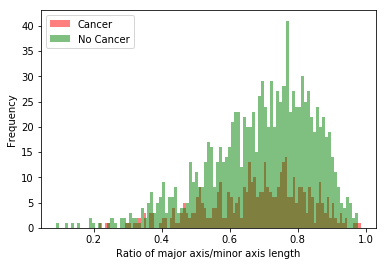

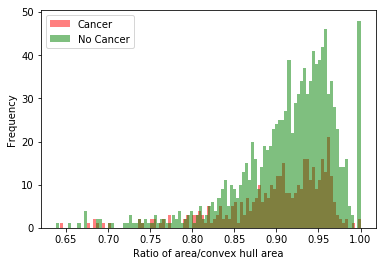

In [4]:
#Exploratory analysis through data visualization
plt.scatter(table["LargestNoduleArea"],table["MeanHU"],color="red")
plt.xlabel("Area (Pixels)")
plt.ylabel("Mean radiodensity (HU)")
plt.show()

plt.hist(table["LargestNoduleArea"],bins=100,alpha=0.5, color="red")
plt.xlabel("Area (Pixels)")
plt.ylabel("Frequency")
plt.show()

plt.hist(table["MeanHU"],bins=100,alpha=0.5, color="red")
plt.xlabel("Mean radiodensity (HU)")
plt.ylabel("Frequency")
plt.show()

plt.scatter(inputfeatures["LargestNoduleArea"].loc[inputfeatures["label"]==True],inputfeatures["MeanHU"].loc[inputfeatures["label"]==True],alpha=0.5, color="red")
plt.scatter(inputfeatures["LargestNoduleArea"].loc[inputfeatures["label"]==False],inputfeatures["MeanHU"].loc[inputfeatures["label"]==False], alpha=0.5, color="green")
plt.xlabel("Area (Pixels)")
plt.ylabel("Mean radiodensity (HU)")
plt.legend(["Cancer","No Cancer"])
plt.show()

plt.hist(inputfeatures["LargestNoduleArea"].loc[inputfeatures["label"]==True],bins=100,alpha=0.5, color="red")
plt.hist(inputfeatures["LargestNoduleArea"].loc[inputfeatures["label"]==False],bins=100,alpha=0.5, color="green")
plt.xlabel("Area (Pixels)")
plt.ylabel("Frequency")
plt.legend(["Cancer","No Cancer"])
plt.show()

plt.hist(inputfeatures["MeanHU"].loc[inputfeatures["label"]==True],bins=100,alpha=0.5, color="red")
plt.hist(inputfeatures["MeanHU"].loc[inputfeatures["label"]==False],bins=100,alpha=0.5, color="green")
plt.xlabel("Mean radiodensity (HU)")
plt.ylabel("Frequency")
plt.legend(["Cancer","No Cancer"])
plt.show()

plt.hist(inputfeatures["NoduleIndex"].loc[inputfeatures["label"]==True],bins=100,alpha=0.5, color="red")
plt.hist(inputfeatures["NoduleIndex"].loc[inputfeatures["label"]==False],bins=100,alpha=0.5, color="green")
plt.xlabel("Slice #")
plt.ylabel("Frequency")
plt.legend(["Cancer","No Cancer"])
plt.show()

plt.hist(inputfeatures["Diameter"].loc[inputfeatures["label"]==True],bins=100,alpha=0.5, color="red")
plt.hist(inputfeatures["Diameter"].loc[inputfeatures["label"]==False],bins=100,alpha=0.5, color="green")
plt.xlabel("Diameter")
plt.ylabel("Frequency")
plt.legend(["Cancer","No Cancer"])
plt.show()

plt.hist(inputfeatures["DiameterMajor"].loc[inputfeatures["label"]==True],bins=100,alpha=0.5, color="red")
plt.hist(inputfeatures["DiameterMajor"].loc[inputfeatures["label"]==False],bins=100,alpha=0.5, color="green")
plt.xlabel("Diameter Major Axis")
plt.ylabel("Frequency")
plt.legend(["Cancer","No Cancer"])
plt.show()

plt.hist(inputfeatures["Eccentricity"].loc[inputfeatures["label"]==True],bins=100,alpha=0.5, color="red")
plt.hist(inputfeatures["Eccentricity"].loc[inputfeatures["label"]==False],bins=100,alpha=0.5, color="green")
plt.xlabel("Ratio of major axis/minor axis length")
plt.ylabel("Frequency")
plt.legend(["Cancer","No Cancer"])
plt.show()

plt.hist(inputfeatures["Spiculation"].loc[inputfeatures["label"]==True],bins=100,alpha=0.5, color="red")
plt.hist(inputfeatures["Spiculation"].loc[inputfeatures["label"]==False],bins=100,alpha=0.5, color="green")
plt.xlabel("Ratio of area/convex hull area")
plt.ylabel("Frequency")
plt.legend(["Cancer","No Cancer"])
plt.show()


In [ ]:
#Normalize data
featureslist=["MeanHU","NoduleIndex","Diameter","DiameterMajor","Spiculation","Eccentricity"]
normalizedfeatures={}
for feature in featureslist:
    mean=np.mean(inputfeatures[feature])
    std=np.std(inputfeatures[feature])
    normalizedfeatures[feature]=(inputfeatures[feature].values-mean)/std
normalizedfeatures=pd.DataFrame(normalizedfeatures)
rawfeatures=inputfeatures.copy()
inputfeatures=normalizedfeatures.copy()

In [51]:
len(inputfeatures)

1512

In [118]:
featureslist=["MeanHU","NoduleIndex","Diameter","DiameterMajor","Spiculation","Eccentricity"]

#diameterpercentiles=[]
percentilefeatures={}

for i,feature in enumerate(featureslist):
    featurestemp=[]
    for j,val in enumerate(rawfeatures[feature]):
        featurestemp.append(percentileofscore(rawfeatures[feature],val))
        percentilefeatures[feature]=np.round(np.array(featurestemp)/2,0)
percentilefeatures=pd.DataFrame(percentilefeatures)

roundedfeatures={}
roundedfeatures[featureslist[0]]=np.round(rawfeatures[featureslist[0]]/100,0)*100

roundedfeatures[featureslist[1]]=np.round(rawfeatures[featureslist[1]]/20,0)*20
roundedfeatures[featureslist[2]]=np.round(rawfeatures[featureslist[2]]/3,0)*3
roundedfeatures[featureslist[3]]=np.round(rawfeatures[featureslist[3]]/4,0)*4
roundedfeatures[featureslist[4]]=np.round(rawfeatures[featureslist[4]]/2.5,2)*2.5
roundedfeatures[featureslist[5]]=np.round(rawfeatures[featureslist[5]]/4,2)*4
roundedfeatures=pd.DataFrame(roundedfeatures)

XtrainR, XtestR, YtrainR, YtestR = train_test_split(roundedfeatures,malignantlabel,test_size=.30, random_state=42)

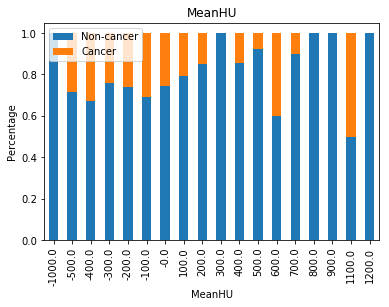

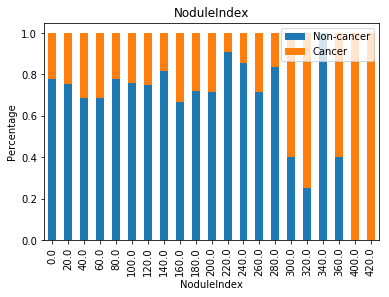

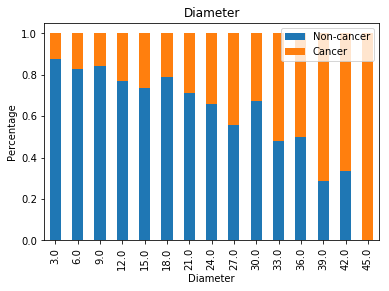

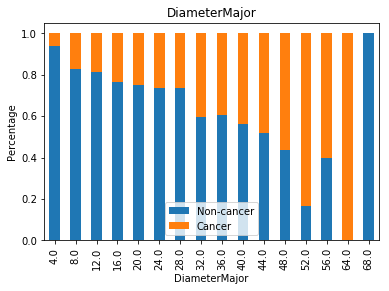

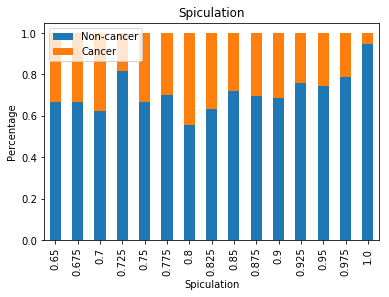

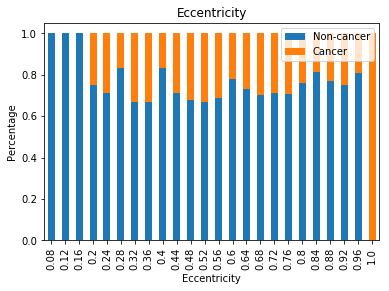

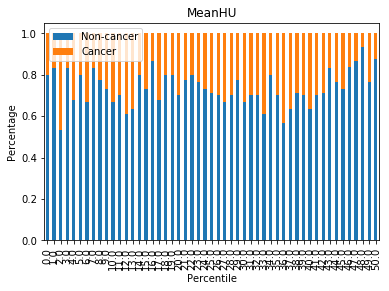

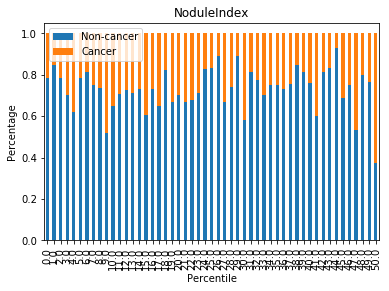

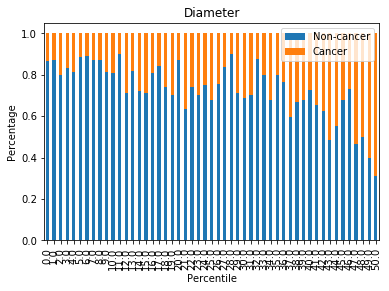

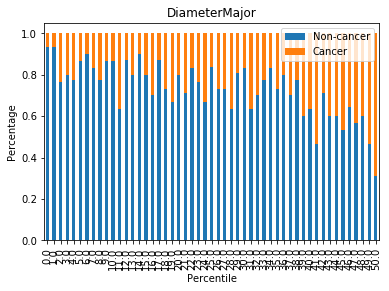

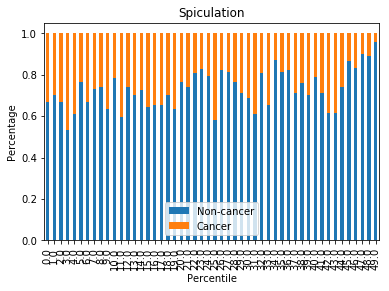

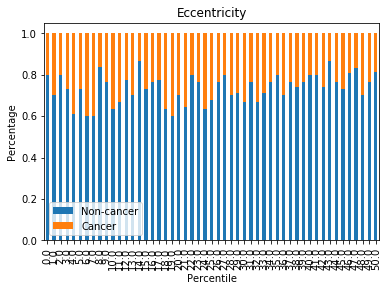

In [119]:
for feature in featureslist:
    dist = pd.crosstab(roundedfeatures[feature],np.array(malignantlabel))
    dist.div(dist.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True)
    plt.ylabel("Percentage")
    plt.legend(["Non-cancer","Cancer"])
    plt.title(feature)
    plt.savefig("stacked"+str(feature)+".png",dpi=150)
    plt.show()

    
for feature in featureslist:
    dist = pd.crosstab(percentilefeatures[feature],np.array(malignantlabel))
    dist.div(dist.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True)
    plt.xlabel("Percentile")
    plt.ylabel("Percentage")
    plt.legend(["Non-cancer","Cancer"])
    plt.title(feature)
    plt.show()

#shift MeanHU values so the lowest value is 0
roundedfeatures[featureslist[0]]=roundedfeatures[featureslist[0]].values-min(roundedfeatures[featureslist[0]].values)


## Model selection, evaluation, and optimization

In [71]:
#Naive bayes may work better if discretized into categories.
#Compare features discretized by transforming into percentiles vs rounded

featureslist=["Diameter"]
clf=MultinomialNB()
scores=cross_val_score(clf,percentilefeatures[featureslist], malignantlabel, cv=StratifiedKFold(n_splits=5, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
print("Performance of features discretized by transforming to percentiles and rounding, multinomial naive bayes")
print(-scores)
print("Cross-validated logloss",-np.mean(scores))

featureslist=["Diameter","Spiculation","MeanHU","Eccentricity"]
clf=MultinomialNB()
print("Performance of features discretized by rounding, multinomial naive bayes.")
scores=cross_val_score(clf,roundedfeatures[featureslist], malignantlabel, cv=StratifiedKFold(n_splits=5, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
print(-scores)
print("Cross-validated logloss",-np.mean(scores))

Performance of features discretized by transforming to percentiles and rounding, multinomial naive bayes
[ 0.58059024  0.58059024  0.57812448  0.57812448  0.57812448]
Cross-validated logloss 0.579110784073
Performance of features discretized by rounding, multinomial naive bayes.
[ 0.56471945  0.56237559  0.54337234  0.54241964  0.54991449]
Cross-validated logloss 0.55256030172


Gaussian Naive Bayes
Average precision score: 0.414522511619
Area under curve: 0.638017121599
Cross-validated logloss 0.585657323734
---------------------------------------
Multinomial Naive Bayes
Average precision score: 0.409703998488
Area under curve: 0.645878714535
Cross-validated logloss 0.744464855609
---------------------------------------
Logistic Regression
Average precision score: 0.413949770137
Area under curve: 0.645074178656
Cross-validated logloss 0.552311390514
---------------------------------------
Random Forest
Average precision score: 0.311568121202
Area under curve: 0.559712697772
Cross-validated logloss 1.53144104481
---------------------------------------
Gradient Boosting
Average precision score: 0.351506917541
Area under curve: 0.589460355878
Cross-validated logloss 0.580872393613
---------------------------------------
SVM with rbf kernel
Average precision score: 0.260709649793
Area under curve: 0.488246828918
Cross-validated logloss 0.579591160447
------------

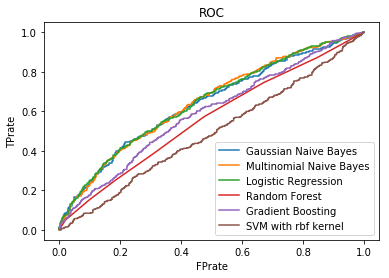

In [120]:
n_splits=24
kfold=StratifiedKFold(n_splits=n_splits, shuffle=False)

featurelist=["Diameter","MeanHU","Spiculation","Eccentricity"]
models=[GaussianNB(), MultinomialNB(),
    LogisticRegression(C=0.1),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
    SVC(C=0.02,kernel='rbf', probability=True),
        SVC(C=0.02, kernel='linear', probability=True)]
name=["Gaussian Naive Bayes", "Multinomial Naive Bayes", "Logistic Regression", "Random Forest", "Gradient Boosting", "SVM with rbf kernel", "SVM with linear kernel"]

predictedmodels={}

for nm, clf in zip(name[:-1], models[:-1]):
    print(nm)
    predicted=[]
    mallabelcv=[]
    for train,test in kfold.split(inputfeatures,malignantlabel):
        if nm==name[1]:
            clf.fit(roundedfeatures[featurelist].iloc[train],[malignantlabel[i] for i in train])
            predicted.append(clf.predict_proba(roundedfeatures[featurelist].iloc[test])[:,1])
        else:
            clf.fit(inputfeatures[featurelist].iloc[train],[malignantlabel[i] for i in train])
            predicted.append(clf.predict_proba(inputfeatures[featurelist].iloc[test])[:,1])
        mallabelcv.append([malignantlabel[i] for i in test])
    if nm==name[1]:        
        scores=cross_val_score(clf,roundedfeatures[featurelist], malignantlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    else:
        scores=cross_val_score(clf,inputfeatures[featurelist], malignantlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    predicted=np.concatenate(np.array(predicted),axis=0)
    mallabelcv=np.concatenate(np.array(mallabelcv),axis=0)
    predictedmodels[nm]=predicted
    roc=roc_curve(mallabelcv,predicted)
    print("Average precision score:", average_precision_score(mallabelcv,predicted))
    print("Area under curve:", auc(roc[0],roc[1]))
    plt.plot(roc[0],roc[1])
    #print(-scores)
    print("Cross-validated logloss",-np.mean(scores))
    print("---------------------------------------")
    #plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(name)
plt.savefig("clfroccomparison.png",dpi=300)
plt.show()

Models averaged: ['Gaussian Naive Bayes', 'Multinomial Naive Bayes', 'Logistic Regression', 'SVM with rbf kernel']
Area under curve: 0.639771861414
Average precision score: 0.394218031035


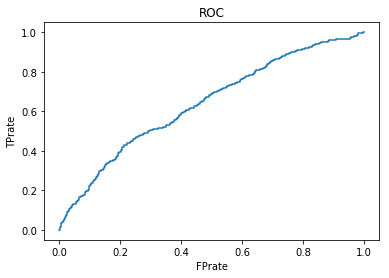

Logistic Regression logloss 0.554847995102
Ensemble of models logloss 0.556005624441


In [78]:
#Ensemble of multiple models by averaging their prediction outputs

predictedmodels=pd.DataFrame(predictedmodels)
models=[name[i] for i in [0,1,2,5]]
predictedmean=np.mean(predictedmodels[models],axis=1)
roc=roc_curve(mallabelcv,predictedmean)
print("Models averaged:",models)
print("Area under curve:", auc(roc[0],roc[1]))
print("Average precision score:", average_precision_score(mallabelcv,predictedmean))
plt.plot(roc[0],roc[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.show()
print("Logistic Regression logloss",log_loss(mallabelcv,predictedmodels[name[2]]))
print("Ensemble of models logloss",log_loss(mallabelcv,predictedmean))

Gaussian Naive Bayes
Average precision score: 0.264615359245
Area under curve: 0.48319454528
Cross-validated logloss 0.601300244897
---------------------------------------
Multinomial Naive Bayes
Average precision score: 0.249989475393
Area under curve: 0.460893695932
Cross-validated logloss 0.590140187634
---------------------------------------
Logistic Regression
Average precision score: 0.243979584085
Area under curve: 0.452701993475
Cross-validated logloss 0.591648749961
---------------------------------------
Random Forest
Average precision score: 0.267203732376
Area under curve: 0.474753549155
Cross-validated logloss 1.50520689192
---------------------------------------
Gradient Boosting
Average precision score: 0.267844392757
Area under curve: 0.48298789395
Cross-validated logloss 0.619576237054
---------------------------------------
SVM with rbf kernel
Average precision score: 0.275422835589
Area under curve: 0.493881371203
Cross-validated logloss 0.590280065819
--------------

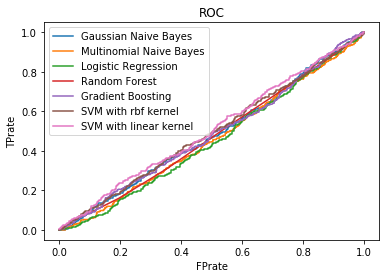

In [33]:
#Benchmark model with stratified random labels

n_splits=24
kfold=StratifiedKFold(n_splits=n_splits, shuffle=False)

featurelist=["Diameter","MeanHU","Spiculation","Eccentricity"]
models=[GaussianNB(), MultinomialNB(),
    LogisticRegression(C=0.1),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
    SVC(C=0.02,kernel='rbf', probability=True),
        SVC(C=0.02, kernel='linear', probability=True)]
name=["Gaussian Naive Bayes", "Multinomial Naive Bayes", "Logistic Regression", "Random Forest", "Gradient Boosting", "SVM with rbf kernel", "SVM with linear kernel"]

predictedmodels={}
tprmodels={}
fprmodels={}


for nm, clf in zip(name[:-1], models[:-1]):
    print(nm)
    predicted=[]
    mallabelcv=[]
    for train,test in kfold.split(inputfeatures,randomlabel):
        if nm==name[1]:
            clf.fit(roundedfeatures[featurelist].iloc[train],[randomlabel[i] for i in train])
            predicted.append(clf.predict_proba(roundedfeatures[featurelist].iloc[test])[:,1])
        else:
            clf.fit(inputfeatures[featurelist].iloc[train],[randomlabel[i] for i in train])
            predicted.append(clf.predict_proba(inputfeatures[featurelist].iloc[test])[:,1])
        mallabelcv.append([randomlabel[i] for i in test])
    if nm==name[1]:        
        scores=cross_val_score(clf,roundedfeatures[featurelist], randomlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    else:
        scores=cross_val_score(clf,inputfeatures[featurelist], randomlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    predicted=np.concatenate(np.array(predicted),axis=0)
    mallabelcv=np.concatenate(np.array(mallabelcv),axis=0)
    predictedmodels[nm]=predicted
    roc=roc_curve(mallabelcv,predicted)
    print("Average precision score:", average_precision_score(mallabelcv,predicted))
    print("Area under curve:", auc(roc[0],roc[1]))
    plt.plot(roc[0],roc[1])
    #print(-scores)
    print("Cross-validated logloss",-np.mean(scores))
    print("---------------------------------------")
    #plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(name)
plt.savefig("clfroccomparison.png",dpi=300)
plt.show()

LogisticRegression(C=2.9999999999999996, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
['Optimized Logistic Regression']
[ 0.58413531  0.54038305  0.5748129   0.52855611  0.54155647]
Cross-validated logloss 0.553888769981
---------------------------------------
[ 0.58393711  0.54044453  0.5747408   0.52868858  0.54150315]
Cross-validated logloss 0.553862832778
---------------------------------------


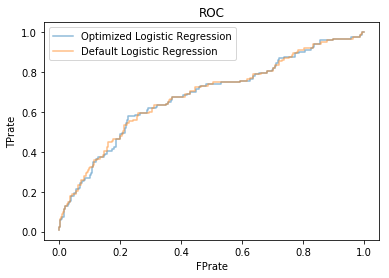

In [28]:
featureslist=['Diameter','Spiculation','Eccentricity','MeanHU']
def fit_model(X, y, clf):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 42)
    params = [{'C':np.arange(0.9,3.1,0.1),'solver':['liblinear'],'penalty':['l1','l2']},
              {'C':np.arange(0.01,0.1,0.01),'solver':['newton-cg'],'penalty':['l2']},
             {'C':np.arange(0.01,0.1,0.01),'solver':['lbfgs'],'penalty':['l2']},
             {'C':np.arange(0.01,0.1,0.01),'solver':['sag'],'penalty':['l2']},
             {'C':np.arange(0.01,0.1,0.01),'solver':['saga'],'penalty':['l1']}]
    grid = GridSearchCV(clf, params, cv=cv_sets, scoring="neg_log_loss", n_jobs=-1)
    grid = grid.fit(X, y)
    return grid.best_estimator_

optimal_lr=fit_model(inputfeatures[featurelist],malignantlabel,LogisticRegression())

print(optimal_lr)

name=["Optimized Logistic Regression"]
print(name)
scores=cross_val_score(optimal_lr,inputfeatures[featurelist], malignantlabel, cv=5, scoring='neg_log_loss')
#print(classification_report(Ytest,model.predict(Xtest[featurelist])))
print(-scores)
print("Cross-validated logloss",-np.mean(scores))
print("---------------------------------------")
clf=optimal_lr
clf.fit(Xtrain[featurelist],Ytrain)
roc=roc_curve(Ytest,clf.predict_proba(Xtest[featurelist])[:,1])

#ROC curve
plt.plot(roc[0],roc[1], alpha=0.5)
#plt.plot(rocrandom[0],rocrandom[1])

scores=cross_val_score(LogisticRegression(),inputfeatures[featurelist], malignantlabel, cv=5, scoring='neg_log_loss')
#print(classification_report(Ytest,model.predict(Xtest[featurelist])))
print(-scores)
print("Cross-validated logloss",-np.mean(scores))
print("---------------------------------------")
clf=LogisticRegression()
clf.fit(Xtrain[featurelist],Ytrain)
roc=roc_curve(Ytest,clf.predict_proba(Xtest[featurelist])[:,1])

#ROC curve
plt.plot(roc[0],roc[1], alpha=0.5)
#plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(['Optimized Logistic Regression', 'Default Logistic Regression'])
plt.show()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
['Optimized Random Forest Classifier']
[ 0.60736264  0.5680371   0.57758907  0.54069499  0.54751972]
Cross-validated logloss 0.568240704889
---------------------------------------
[ 1.91837366  1.87828671  1.70397392  1.02801084  0.94509846]
Cross-validated logloss 1.49474871942
---------------------------------------


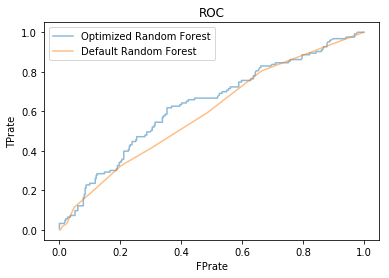

In [34]:
featureslist=['Diameter','Spiculation','Eccentricity','MeanHU']
def fit_model(X, y, clf):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 42)
    params = {'n_estimators':[2,5,7,8,9,10,15],'max_depth':[2,3,4,5,6,7,8,None]}
    grid = GridSearchCV(clf, params, cv=cv_sets, scoring="neg_log_loss", n_jobs=-1)
    grid = grid.fit(X, y)
    return grid.best_estimator_

optimal_rf=fit_model(roundedfeatures[featurelist],malignantlabel,RandomForestClassifier())

print(optimal_rf)

name=["Optimized Random Forest Classifier"]
print(name)
scores=cross_val_score(optimal_rf,roundedfeatures[featurelist], malignantlabel, cv=5, scoring='neg_log_loss')
#print(classification_report(Ytest,model.predict(Xtest[featurelist])))
print(-scores)
print("Cross-validated logloss",-np.mean(scores))
print("---------------------------------------")
clf=optimal_rf
clf.fit(Xtrain[featurelist],Ytrain)
roc=roc_curve(Ytest,clf.predict_proba(Xtest[featurelist])[:,1])

#ROC curve
plt.plot(roc[0],roc[1], alpha=0.5)
#plt.plot(rocrandom[0],rocrandom[1])

scores=cross_val_score(RandomForestClassifier(),inputfeatures[featurelist], malignantlabel, cv=5, scoring='neg_log_loss')
#print(classification_report(Ytest,model.predict(Xtest[featurelist])))
print(-scores)
print("Cross-validated logloss",-np.mean(scores))
print("---------------------------------------")
clf=RandomForestClassifier()
clf.fit(Xtrain[featurelist],Ytrain)
roc=roc_curve(Ytest,clf.predict_proba(Xtest[featurelist])[:,1])

#ROC curve
plt.plot(roc[0],roc[1], alpha=0.5)
#plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(['Optimized Random Forest', 'Default Random Forest'])
plt.show()

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=7,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
['Optimized Gradient Boosting Classifier']
[ 0.58064747  0.55548926  0.57106105  0.54778498  0.55003075]
Cross-validated logloss 0.561002702355
---------------------------------------
[ 0.62537118  0.56627308  0.61344228  0.57352499  0.56654021]
Cross-validated logloss 0.589030349815
---------------------------------------


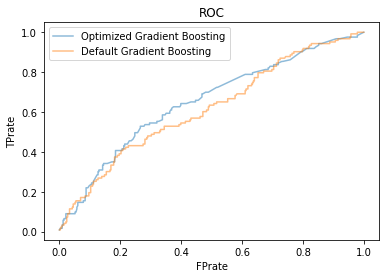

In [89]:
featureslist=['Diameter','Spiculation','Eccentricity','MeanHU']
def fit_model(X, y, clf):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 42)
    params = {'loss':['deviance','exponential'],'learning_rate':np.arange(0.01,0.13,0.3),
             'n_estimators':np.arange(25,200,25),'max_depth':np.arange(2,8,1),
             'max_leaf_nodes':np.arange(2,10,1)}
    grid = GridSearchCV(clf, params, cv=cv_sets, scoring="neg_log_loss", n_jobs=-1)
    grid = grid.fit(X, y)
    return grid.best_estimator_

optimal_gb=fit_model(inputfeatures[featurelist],malignantlabel,GradientBoostingClassifier())

print(optimal_gb)

name=["Optimized Gradient Boosting Classifier"]
print(name)
scores=cross_val_score(optimal_gb,inputfeatures[featurelist], malignantlabel, cv=5, scoring='neg_log_loss')
#print(classification_report(Ytest,model.predict(Xtest[featurelist])))
print(-scores)
print("Cross-validated logloss",-np.mean(scores))
print("---------------------------------------")
clf=optimal_gb
clf.fit(Xtrain[featurelist],Ytrain)
roc=roc_curve(Ytest,clf.predict_proba(Xtest[featurelist])[:,1])
#print(clf.feature_importances)
#ROC curve
plt.plot(roc[0],roc[1], alpha=0.5)
#plt.plot(rocrandom[0],rocrandom[1])

scores=cross_val_score(GradientBoostingClassifier(),inputfeatures[featurelist], malignantlabel, cv=5, scoring='neg_log_loss')
#print(classification_report(Ytest,model.predict(Xtest[featurelist])))
print(-scores)
print("Cross-validated logloss",-np.mean(scores))
print("---------------------------------------")
clf=GradientBoostingClassifier()
clf.fit(Xtrain[featurelist],Ytrain)
roc=roc_curve(Ytest,clf.predict_proba(Xtest[featurelist])[:,1])

#ROC curve
plt.plot(roc[0],roc[1], alpha=0.5)
#plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(['Optimized Gradient Boosting', 'Default Gradient Boosting'])
plt.show()

In [90]:
featureslist=['Diameter','Spiculation','Eccentricity','MeanHU']
def fit_model(X, y, clf):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 42)
    params = {'alpha':np.arange(0.01,0.2,0.01)}
    grid = GridSearchCV(clf, params, cv=cv_sets, scoring="neg_log_loss", n_jobs=-1)
    grid = grid.fit(X, y)
    return grid.best_estimator_

optimal_mnb=fit_model(roundedfeatures[featurelist],malignantlabel,MultinomialNB())

print(optimal_mnb)


MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)


Gaussian Naive Bayes
Average precision score: 0.414522511619
Area under curve: 0.638017121599
Cross-validated logloss 0.585022669107
---------------------------------------
Multinomial Naive Bayes
Average precision score: 0.410012824874
Area under curve: 0.645654609834
Cross-validated logloss 0.55280005726
---------------------------------------
Logistic Regression
Average precision score: 0.415806776411
Area under curve: 0.644832145578
Cross-validated logloss 0.55254268468
---------------------------------------
Random Forest
Average precision score: 0.376921978648
Area under curve: 0.614972435122
Cross-validated logloss 0.563315068589
---------------------------------------
Gradient Boosting
Average precision score: 0.377418451084
Area under curve: 0.617288557214
Cross-validated logloss 0.557275128346
---------------------------------------
SVM with rbf kernel
Average precision score: 0.271426829941
Area under curve: 0.501749137197
Cross-validated logloss 0.579370953538
-------------

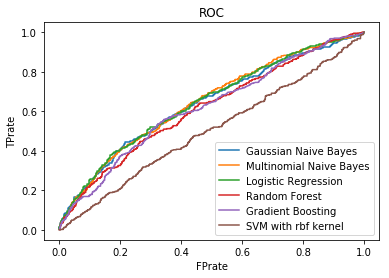

In [91]:
n_splits=24
kfold=StratifiedKFold(n_splits=n_splits, shuffle=False)

featurelist=["Diameter","MeanHU","Spiculation","Eccentricity"]
models=[GaussianNB(), optimal_mnb,
    optimal_lr,
        optimal_rf,
        optimal_gb,
    SVC(C=0.02,kernel='rbf', probability=True),
        SVC(C=0.02, kernel='linear', probability=True)]
name=["Gaussian Naive Bayes", "Multinomial Naive Bayes", "Logistic Regression", "Random Forest", "Gradient Boosting", "SVM with rbf kernel", "SVM with linear kernel"]

predictedmodels={}



for nm, clf in zip(name[:-1], models[:-1]):
    print(nm)
    predicted=[]
    mallabelcv=[]
    for train,test in kfold.split(inputfeatures,malignantlabel):
        if nm==name[1]:
            clf.fit(roundedfeatures[featurelist].iloc[train],[malignantlabel[i] for i in train])
            predicted.append(clf.predict_proba(roundedfeatures[featurelist].iloc[test])[:,1])
        else:
            clf.fit(inputfeatures[featurelist].iloc[train],[malignantlabel[i] for i in train])
            predicted.append(clf.predict_proba(inputfeatures[featurelist].iloc[test])[:,1])
        mallabelcv.append([malignantlabel[i] for i in test])
    if nm==name[1]:        
        scores=cross_val_score(clf,roundedfeatures[featurelist], malignantlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    else:
        scores=cross_val_score(clf,inputfeatures[featurelist], malignantlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    predicted=np.concatenate(np.array(predicted),axis=0)
    mallabelcv=np.concatenate(np.array(mallabelcv),axis=0)
    predictedmodels[nm]=predicted
    roc=roc_curve(mallabelcv,predicted)
    print("Average precision score:", average_precision_score(mallabelcv,predicted))
    print("Area under curve:", auc(roc[0],roc[1]))
    plt.plot(roc[0],roc[1])
    #print(-scores)
    print("Cross-validated logloss",-np.mean(scores))
    print("---------------------------------------")
    #plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(name)
plt.savefig("clfroccomparison.png",dpi=300)
plt.show()

Models averaged: ['Multinomial Naive Bayes', 'Logistic Regression']
Area under curve: 0.645943704899
Average precision score: 0.413326782175


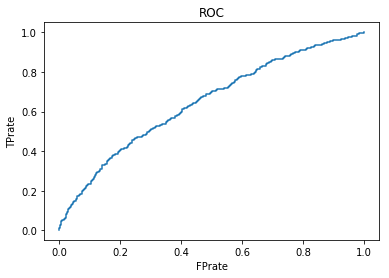

Logistic Regression logloss 0.551825461897
Ensemble of models logloss 0.551930318918


In [106]:
#Ensemble of multiple models by averaging their prediction outputs

predictedmodels=pd.DataFrame(predictedmodels)
models=[name[i] for i in [1,2]]
predictedmean=np.mean(predictedmodels[models],axis=1)
roc=roc_curve(mallabelcv,predictedmean)
print("Models averaged:",models)
print("Area under curve:", auc(roc[0],roc[1]))
print("Average precision score:", average_precision_score(mallabelcv,predictedmean))
plt.plot(roc[0],roc[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.show()
print("Logistic Regression logloss",log_loss(mallabelcv,predictedmodels[name[2]]))
print("Ensemble of models logloss",log_loss(mallabelcv,predictedmean))

Gaussian Naive Bayes
Average precision score: 0.292869667393
Area under curve: 0.505311216148
Cross-validated logloss 0.603750022224
---------------------------------------
Multinomial Naive Bayes
Average precision score: 0.289291994353
Area under curve: 0.5050129433
Cross-validated logloss 0.592039297402
---------------------------------------
Logistic Regression
Average precision score: 0.265452572085
Area under curve: 0.482313726429
Cross-validated logloss 0.593946852487
---------------------------------------
Random Forest
Average precision score: 0.272393993431
Area under curve: 0.468075008001
Cross-validated logloss 0.603813293483
---------------------------------------
Gradient Boosting
Average precision score: 0.286135769747
Area under curve: 0.50192788764
Cross-validated logloss 0.596427710433
---------------------------------------
SVM with rbf kernel
Average precision score: 0.278733456464
Area under curve: 0.510783543177
Cross-validated logloss 0.59313741474
---------------

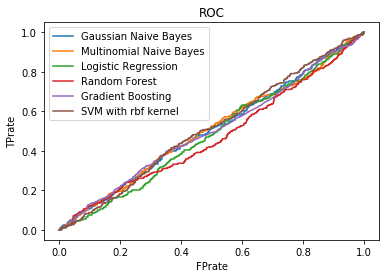

In [107]:
n_splits=24
kfold=StratifiedKFold(n_splits=n_splits, shuffle=False)

featurelist=["Diameter","MeanHU","Spiculation","Eccentricity"]
models=[GaussianNB(), optimal_mnb,
    optimal_lr,
        optimal_rf,
        optimal_gb,
    SVC(C=0.02,kernel='rbf', probability=True),
        SVC(C=0.02, kernel='linear', probability=True)]
name=["Gaussian Naive Bayes", "Multinomial Naive Bayes", "Logistic Regression", "Random Forest", "Gradient Boosting", "SVM with rbf kernel", "SVM with linear kernel"]

predictedmodels={}

for nm, clf in zip(name[:-1], models[:-1]):
    print(nm)
    predicted=[]
    mallabelcv=[]
    for train,test in kfold.split(inputfeatures,randomlabel):
        if nm==name[1]:
            clf.fit(roundedfeatures[featurelist].iloc[train],[randomlabel[i] for i in train])
            predicted.append(clf.predict_proba(roundedfeatures[featurelist].iloc[test])[:,1])
        else:
            clf.fit(inputfeatures[featurelist].iloc[train],[randomlabel[i] for i in train])
            predicted.append(clf.predict_proba(inputfeatures[featurelist].iloc[test])[:,1])
        mallabelcv.append([randomlabel[i] for i in test])
    if nm==name[1]:        
        scores=cross_val_score(clf,roundedfeatures[featurelist], randomlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    else:
        scores=cross_val_score(clf,inputfeatures[featurelist], randomlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    predicted=np.concatenate(np.array(predicted),axis=0)
    mallabelcv=np.concatenate(np.array(mallabelcv),axis=0)
    predictedmodels[nm]=predicted
    roc=roc_curve(mallabelcv,predicted)
    print("Average precision score:", average_precision_score(mallabelcv,predicted))
    print("Area under curve:", auc(roc[0],roc[1]))
    plt.plot(roc[0],roc[1])
    #print(-scores)
    print("Cross-validated logloss",-np.mean(scores))
    print("---------------------------------------")
    #plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(name)
plt.savefig("clfroccomparison.png",dpi=300)
plt.show()

## Sensitivity Analysis

Gaussian Naive Bayes
Average precision score: 0.267390179676
Area under curve: 0.519349199946
Cross-validated logloss 0.581929959138
---------------------------------------
Multinomial Naive Bayes
Average precision score: 0.410012824874
Area under curve: 0.645654609834
Cross-validated logloss 0.552565700265
---------------------------------------
Logistic Regression
Average precision score: 0.277523278995
Area under curve: 0.53277643315
Cross-validated logloss 0.552853636955
---------------------------------------
Random Forest
Average precision score: 0.307595764349
Area under curve: 0.570125722738
Cross-validated logloss 0.566301162721
---------------------------------------
Gradient Boosting
Average precision score: 0.320184953328
Area under curve: 0.59362534176
Cross-validated logloss 0.558803268982
---------------------------------------
SVM with rbf kernel
Average precision score: 0.263748343031
Area under curve: 0.497165075523
Cross-validated logloss 0.571000436593
-------------

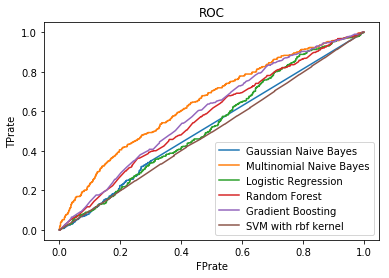

In [108]:
n_splits=24
kfold=StratifiedKFold(n_splits=n_splits, shuffle=False)

featurelist=["Diameter","MeanHU","Spiculation","Eccentricity"]
models=[GaussianNB(), optimal_mnb,
    optimal_lr,
        optimal_rf,
        optimal_gb,
    SVC(C=0.02,kernel='rbf', probability=True),
        SVC(C=0.02, kernel='linear', probability=True)]
name=["Gaussian Naive Bayes", "Multinomial Naive Bayes", "Logistic Regression", "Random Forest", "Gradient Boosting", "SVM with rbf kernel", "SVM with linear kernel"]

predictedmodels={}



for nm, clf in zip(name[:-1], models[:-1]):
    print(nm)
    predicted=[]
    mallabelcv=[]
    for train,test in kfold.split(inputfeatures,malignantlabel):
        if nm==name[1]:
            clf.fit(roundedfeatures[featurelist].iloc[train],[malignantlabel[i] for i in train])
            predicted.append(clf.predict_proba(roundedfeatures[featurelist].iloc[test])[:,1])
        else:
            clf.fit(roundedfeatures[featurelist].iloc[train],[malignantlabel[i] for i in train])
            predicted.append(clf.predict_proba(inputfeatures[featurelist].iloc[test])[:,1])
        mallabelcv.append([malignantlabel[i] for i in test])
    if nm==name[1]:        
        scores=cross_val_score(clf,roundedfeatures[featurelist], malignantlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    else:
        scores=cross_val_score(clf,roundedfeatures[featurelist], malignantlabel, cv=StratifiedKFold(n_splits=n_splits, shuffle=True), n_jobs=-1, scoring='neg_log_loss')
    predicted=np.concatenate(np.array(predicted),axis=0)
    mallabelcv=np.concatenate(np.array(mallabelcv),axis=0)
    predictedmodels[nm]=predicted
    roc=roc_curve(mallabelcv,predicted)
    print("Average precision score:", average_precision_score(mallabelcv,predicted))
    print("Area under curve:", auc(roc[0],roc[1]))
    plt.plot(roc[0],roc[1])
    #print(-scores)
    print("Cross-validated logloss",-np.mean(scores))
    print("---------------------------------------")
    #plt.plot(rocrandom[0],rocrandom[1])
plt.title('ROC')
plt.ylabel('TPrate')
plt.xlabel('FPrate')
plt.legend(name)
plt.savefig("clfroccomparison.png",dpi=300)
plt.show()